In [1]:
import tensorflow as tf

In [2]:
from tensorflow.keras.layers import Input,Dense,Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg19 import VGG19,preprocess_input

import numpy as np
import glob
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
from datetime import datetime
from tensorflow.keras.callbacks import ModelCheckpoint


import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

np.random.seed(42)
from sklearn.metrics import confusion_matrix

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding

from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder

In [3]:
skin_df = pd.read_csv(r'C:\Users\KIIT\Downloads\Skin cancer\HAM10000_metadata.csv')

In [4]:
SIZE = 224

In [5]:
le = LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [6]:
skin_df['label'] = le.transform(skin_df["dx"]) 
print(skin_df.sample(10))

        lesion_id      image_id   dx    dx_type   age     sex  \
1617  HAM_0007180  ISIC_0033272  mel      histo  65.0    male   
8128  HAM_0007195  ISIC_0031923   nv      histo  40.0  female   
2168  HAM_0001835  ISIC_0026652  mel      histo  65.0    male   
1090  HAM_0000465  ISIC_0030583  bkl  consensus  35.0  female   
7754  HAM_0001720  ISIC_0034010   nv      histo  45.0    male   
8071  HAM_0006333  ISIC_0024424   nv      histo  35.0    male   
7423  HAM_0004548  ISIC_0032832   nv      histo  45.0  female   
8984  HAM_0006526  ISIC_0026671   nv      histo  55.0    male   
2310  HAM_0003102  ISIC_0032389  mel      histo  65.0    male   
7256  HAM_0004260  ISIC_0025525   nv      histo  65.0    male   

         localization  label  
1617             face      4  
8128  lower extremity      5  
2168             back      4  
1090            trunk      2  
7754          abdomen      5  
8071            trunk      5  
7423  upper extremity      5  
8984  lower extremity      5  
2310 

In [7]:
from sklearn.utils import resample
print(skin_df['label'].value_counts())

5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: label, dtype: int64


In [8]:
df_0 = skin_df[skin_df['label'] == 0]
df_1 = skin_df[skin_df['label'] == 1]
df_2 = skin_df[skin_df['label'] == 2]
df_3 = skin_df[skin_df['label'] == 3]
df_4 = skin_df[skin_df['label'] == 4]
df_5 = skin_df[skin_df['label'] == 5]
df_6 = skin_df[skin_df['label'] == 6]

In [9]:
n_samples=500 
df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42) 
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42) 
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)

In [10]:
skin_df_balanced = pd.concat([df_0_balanced, df_1_balanced, 
                              df_2_balanced, df_3_balanced, 
                              df_4_balanced, df_5_balanced, df_6_balanced])

In [11]:
print(skin_df_balanced['label'].value_counts())

0    500
1    500
2    500
3    500
4    500
5    500
6    500
Name: label, dtype: int64


In [12]:
image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(r'C:\Users\KIIT\Downloads\Skin cancer\images 1&2', '*', '*.jpg'))}

In [13]:
skin_df_balanced['path'] = skin_df['image_id'].map(image_path.get)
#Use the path to read images.
skin_df_balanced['image'] = skin_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))

In [14]:
X = np.asarray(skin_df_balanced['image'].tolist())
X = X/255.  # Scale values to 0-1. You can also used standardscaler or other scaling methods.
Y=skin_df_balanced['label']  #Assign label values to Y
Y_cat = to_categorical(Y, num_classes=7) #Convert to categorical as this is a multiclass classification problem
#Split to training and testing
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)

In [15]:
SIZE = [ 224 , 224 , 3 ]

 
vgg = VGG19( include_top = False,
            input_shape = SIZE,
            weights = 'imagenet')


vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [16]:
for  layer in vgg.layers:
    layer.trainable = False

In [17]:
x = Flatten()(vgg.output)


prediction = Dense( 7 , activation = 'softmax' )(x)


model = Model( inputs = vgg.input , outputs = prediction )


model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [18]:
adam=Adam()


model.compile( loss = 'categorical_crossentropy',
              optimizer = adam,
              metrics = ['accuracy'] )

In [19]:
checkpoint = ModelCheckpoint(filepath = 'vgg19.h5' , verbose = 2 , save_best_only = True )
callbacks = [checkpoint]
start = datetime.now()

batch_size = 16 
epochs = 20

history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(x_test, y_test),
    verbose=2)
score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])



Epoch 1/20
165/165 - 607s - loss: 1.8122 - accuracy: 0.3707 - val_loss: 2.1998 - val_accuracy: 0.2309 - 607s/epoch - 4s/step
Epoch 2/20
165/165 - 643s - loss: 1.2675 - accuracy: 0.5467 - val_loss: 1.1842 - val_accuracy: 0.5554 - 643s/epoch - 4s/step
Epoch 3/20
165/165 - 585s - loss: 0.9578 - accuracy: 0.6530 - val_loss: 1.0566 - val_accuracy: 0.6183 - 585s/epoch - 4s/step
Epoch 4/20
165/165 - 680s - loss: 0.7899 - accuracy: 0.7173 - val_loss: 1.1844 - val_accuracy: 0.6034 - 680s/epoch - 4s/step
Epoch 5/20
165/165 - 704s - loss: 0.6881 - accuracy: 0.7669 - val_loss: 1.0473 - val_accuracy: 0.6583 - 704s/epoch - 4s/step
Epoch 6/20
165/165 - 730s - loss: 0.7014 - accuracy: 0.7520 - val_loss: 1.5039 - val_accuracy: 0.4743 - 730s/epoch - 4s/step
Epoch 7/20
165/165 - 707s - loss: 0.5764 - accuracy: 0.8000 - val_loss: 1.2221 - val_accuracy: 0.5943 - 707s/epoch - 4s/step
Epoch 8/20
165/165 - 707s - loss: 0.5420 - accuracy: 0.8149 - val_loss: 0.9230 - val_accuracy: 0.7040 - 707s/epoch - 4s/step


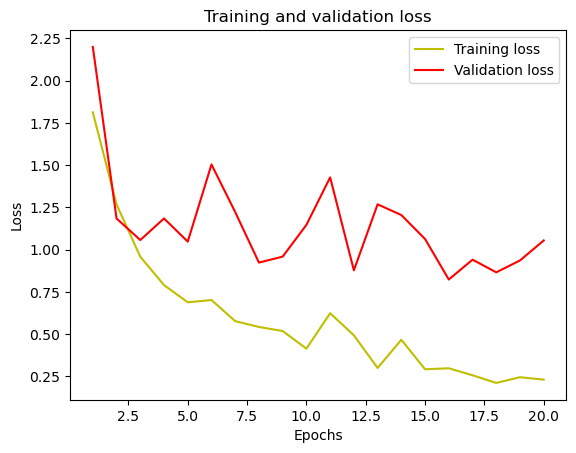

In [20]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

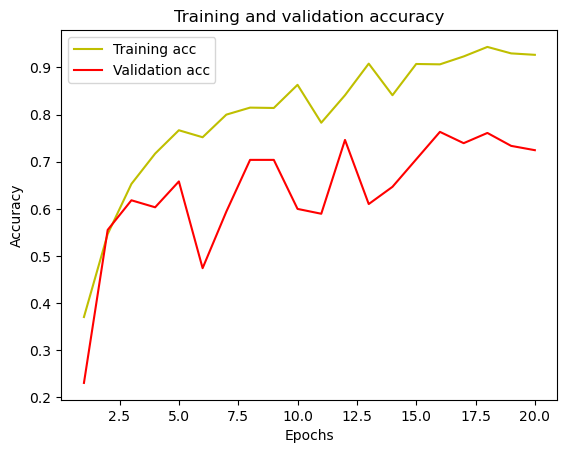

In [24]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(epochs, accuracy, 'y', label='Training acc')
plt.plot(epochs, val_accuracy, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [25]:
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 
# Convert test data to one hot vectors
y_true = np.argmax(y_test, axis = 1) 

28/28 [==============================] - 149s 5s/step


<Axes: >

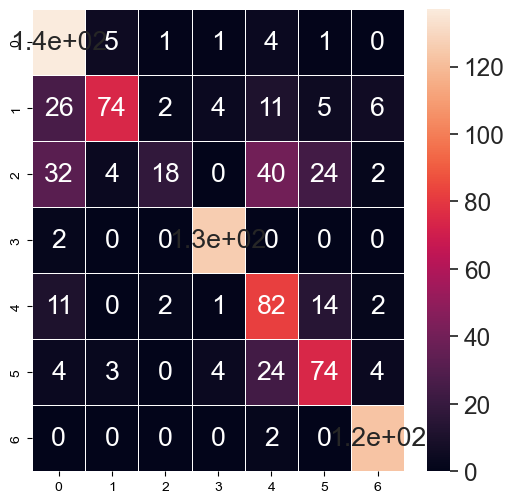

In [26]:
cm = confusion_matrix(y_true, y_pred_classes)

fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

Text(0, 0.5, 'Fraction of incorrect predictions')

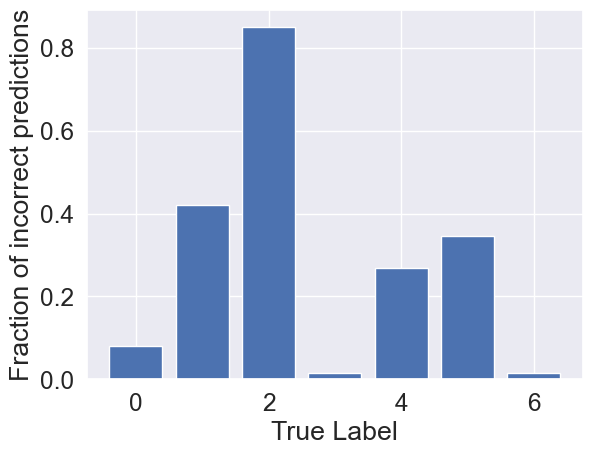

In [27]:
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.bar(np.arange(7), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')